# Feature Engineering

## Introducción
La ingeniería de características es una etapa crucial en la creación de modelos predictivos. En esta notebook, se crearán y seleccionarán características relevantes que capturen la estacionalidad, las tendencias de ventas, y otros patrones importantes.


## 1. Importación de Librerías

In [1]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

## 2. Configuración del Entorno

In [3]:
# Configuración de opciones de pandas
pd.set_option('display.max_columns', None)

# Configuración de estilo para las visualizaciones
sns.set(style="whitegrid")

# Configuración para reproducibilidad
np.random.seed(42)

data_dir = '../data/'
models_dir = '../models/'

## 3. Carga de Datos

In [4]:
# Cargar los datos desde archivos CSV
df = pd.read_excel(f'{data_dir}db_.xlsx', 'BBDD')



print(df.shape)
df.head()

(92212, 6)


,date,expirationDate,paymentDate,sector,payerSalesSegment,amountFinanced
0,2022-05-28,2022-06-25,NaT,Ganadería,6,399091.0
1,2022-05-28,2022-07-12,NaT,Consumo Basico,4,305235.0
2,2022-05-28,2022-07-27,NaT,Acuicultura y Pesca,5,2350269.0
3,2022-05-28,2022-07-16,NaT,Construcción de Viviendas,5,9827729.0
4,2022-05-28,2022-06-25,NaT,Ganadería,6,5156437.0


## 4. Preparacion de la base

In [14]:
## imputamos los null por 1


df['date']=pd.to_datetime(df['date'])

In [28]:
# ya que para cada fecha que se tenia venta se analizo a que segmento pertenecia, a esa fecha lo voy denominar fecha observacion, al analizar los datos historicos hay varias fecha observacion que product_id y city pertencen a un determinado segmento 

## por cuestiones de practiva se va tomar la ultima fecha observacion ya que estaria reflejando el comportamiento mas reciente del producto 
## esta tarea de seleccionar la muestra y elegir la fecha de observacion es toda una ciencia  


In [47]:
## para cada uno de estas fechas (date) el producto pertenence al segmento . pero para el modelamiento necesito una fecha de observacion analizar que el sujeto tenga desempeno (es decir los dias que voy a pronosticar para luego analizar la performance del modelo)

on = ['product_id','city']

df_unico=df[on+['date']].drop_duplicates()

df_muestra=df_unico.groupby(on).agg(date=('date','max')).reset_index()

print(df_muestra.shape)
df_muestra.head()


(1099, 3)


,product_id,city,date
0,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B1,2024-07-10
1,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-08-06
2,010facf4-08f0-4b25-9eef-2522a8caed4b,B1,2024-08-05
3,015ad371-f82f-4eba-ab3a-dc4c77262d23,B2,2024-07-10
4,015ad371-f82f-4eba-ab3a-dc4c77262d23,B3,2024-08-06


In [60]:
sales_df = pd.read_csv(f'{data_dir}product_sales.csv')
geo_df = pd.read_csv(f'{data_dir}geo.csv')

import pandasql as psql

# Definir la consulta SQL ajustada
query = """
WITH merged_data AS (
    SELECT 
        s.product_id, 
        s.date,
        s.sales, 
        s.zipcode, 
        g.s_zipcode,
        g.e_zipcode,
        g.country,
        g.city
    FROM 
        sales_df s
    LEFT JOIN 
        geo_df g
    ON s.country = g.country 
        AND s.zipcode >= g.s_zipcode 
        AND (s.zipcode < g.e_zipcode 
            OR (s.country='M' AND s.zipcode=99999) 
            OR (s.country='B' AND s.zipcode=99999999))
    WHERE 1=1 
        and s.country = 'B'
        and s.zipcode is not null

)
SELECT 
    a.*
FROM 
    merged_data a
INNER JOIN 
    df_muestra b
ON a.product_id = b.product_id 
    AND a.city = b.city 
    AND a.date <= b.date 
"""

# Ejecutar la consulta SQL con pandasql
df_merge_b_4 = psql.sqldf(query, locals())

print(df_merge_b_4.shape)

df_merge_b_4.head()


(145980, 8)


,product_id,date,sales,zipcode,s_zipcode,e_zipcode,country,city
0,c5b9d75d-86bc-4e87-87c4-1d751096d21a,2024-07-10,1.0,13212117.0,13201000,13230001,B,B3
1,b7a56357-a4a2-4bdf-94be-cb82636bd7ec,2024-07-12,1.0,88340455.0,88330003,88350001,B,B2
2,2aac125e-5623-4206-8161-881a28d7826c,2024-07-19,9999,99840000.0,99840000,99910000,B,B2
3,eb83cdae-2684-4046-99de-a999cb593e12,2024-06-10,1.0,19970308.0,19920000,20010000,B,B3
4,b3b40437-8657-4fb8-a3dc-ed4ed9125b6e,2024-07-10,1.0,15910000.0,15900000,15920000,B,B3


In [61]:
df_merge_b_4['date']=pd.to_datetime(df_merge_b_4['date'])

df_merge_b_4['sales']=pd.to_numeric(df_merge_b_4['sales'],errors='coerce')
df_merge_b_4['sales']=np.where(df_merge_b_4['sales'].isin([9999,np.nan]),1,df_merge_b_4['sales']).astype(int)

## 5. Feature Engineering

### La Importancia de la Creación de Features

La creación de features es, como su nombre lo indica, una verdadera ingeniería. En mi experiencia, es una parte fundamental que puede marcar una gran diferencia en el rendimiento de un modelo, a menudo incluso más importante que la elección del algoritmo en sí.

Me gusta desarrollar una batería de features que abarque diferentes naturalezas y temporalidades, así como diversos ratios. Por ejemplo, es probable que exista una correlación entre las ventas de un mismo producto en diferentes ciudades, o que podamos utilizar features similares a los que se emplean en series temporales del mercado de valores.

Además, la experiencia en el negocio es invaluable en este proceso. Un ejemplo claro es el uso de un calendario de eventos importantes, que puede ofrecer insights clave para mejorar las predicciones.

Sin embargo, por razones de tiempo, me limitaré a generar features derivados de las fechas.

Asumiendo que conuntry b es Brasil , aca hay un calendario comercial de brasil 
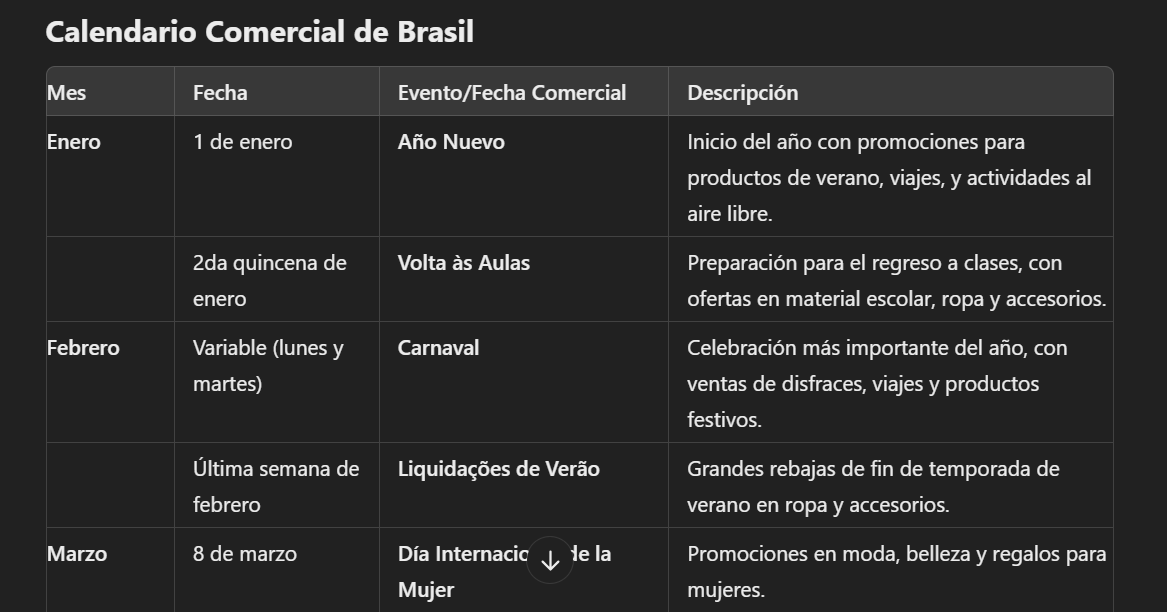

In [50]:
## como necesito la serie a nivel product_id, date, city, sales lo voy agrupar

df_att=df_merge_b_4.groupby(['product_id','date','city']).agg(sales=('sales','sum')).reset_index()
print(df_att.shape)
df_att.head()

(23972, 4)


,product_id,date,city,sales
0,00dac0d3-3b8f-4d7f-919a-bfb852e11148,2024-06-01,B3,2
1,00dac0d3-3b8f-4d7f-919a-bfb852e11148,2024-06-03,B3,3
2,00dac0d3-3b8f-4d7f-919a-bfb852e11148,2024-06-04,B3,2
3,00dac0d3-3b8f-4d7f-919a-bfb852e11148,2024-06-05,B3,1
4,00dac0d3-3b8f-4d7f-919a-bfb852e11148,2024-06-07,B3,2


In [51]:
## asumiendo que los dia entre las fecha inicial y la ultima venta reportada que no aparece sales es porque no se vendio . por lo tanto voy a completar con 0
## tambien se podria analizar que hay dias que no se vende por cuestiones de feriados etc 
## para este analisis asumimos que las fechas que no aparecen las ventas fueron 0



existing_combinations = df_att[['product_id', 'city']].drop_duplicates()

complete_data = pd.DataFrame()

# Iterar sobre cada combinación existente
for _, row in tqdm(existing_combinations.iterrows()):

    product_id = row['product_id']
    city = row['city']
    
    # Filtrar el DataFrame original para la combinación actual
    filtered_df = df_att[(df_att['product_id'] == product_id) & 
                           (df_att['city'] == city)]
    
    # Crear un rango de fechas desde la primera hasta la última fecha en el DataFrame filtrado
    
    date_range = pd.date_range(start=filtered_df['date'].min(), end=filtered_df['date'].max())
    
    # Crear un DataFrame con la combinación actual y el rango de fechas completo
    date_df = pd.DataFrame({
        'product_id': product_id,
        'city': city,
        'date': date_range
    })
    
    # Hacer un merge con el DataFrame filtrado para agregar las ventas, completando con 0 las fechas faltantes
    merged_df = pd.merge(date_df, filtered_df, how='left', on=['product_id', 'city', 'date'])
    merged_df['sales'] = merged_df['sales'].fillna(0)
    
    # Agregar el DataFrame resultante a la lista
    complete_data= pd.concat([complete_data,merged_df])

print(complete_data.shape)
# Ver el resultado
complete_data.head()

1099it [00:03, 347.36it/s]

(59880, 4)


,product_id,city,date,sales
0,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-01,2.0
1,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-02,0.0
2,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-03,3.0
3,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-04,2.0
4,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-05,1.0


In [52]:
# Función para añadir variables de calendario a un DataFrame


def day_of_week_cyclical_encoding(data):
    """

    """
    data['day_of_week'] = data['date'].dt.dayofweek
    data['sin_day_of_week'] = np.sin(2*np.pi*data['day_of_week']/7)
    data['cos_day_of_week'] = np.cos(2*np.pi*data['day_of_week']/7)
    
    return data

In [53]:
complete_data=day_of_week_cyclical_encoding(complete_data)
complete_data.head()

,product_id,city,date,sales,day_of_week,sin_day_of_week,cos_day_of_week
0,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-01,2.0,5,-0.974928,-0.222521
1,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-02,0.0,6,-0.781831,0.623490
2,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-03,3.0,0,0.000000,1.000000
3,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-04,2.0,1,0.781831,0.623490
4,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-05,1.0,2,0.974928,-0.222521


In [54]:
## se aprecia una correlacion debil con las ventas en termino generales 

complete_data[['sales','day_of_week','sin_day_of_week','cos_day_of_week']].corr()

## se podria agregar una variable dummy si es finde semana o no

,sales,day_of_week,sin_day_of_week,cos_day_of_week
sales,1.000000,-0.027080,0.028162,0.006039
day_of_week,-0.027080,1.000000,-0.733014,-0.356031
sin_day_of_week,0.028162,-0.733014,1.000000,0.000219
cos_day_of_week,0.006039,-0.356031,0.000219,1.000000


In [55]:
def day_of_week_cyclical_encoding(data):
    """

    """
    data['day_of_week'] = data['date'].dt.dayofweek
    data['sin_day_of_week'] = np.sin(2*np.pi*data['day_of_week']/7)
    data['cos_day_of_week'] = np.cos(2*np.pi*data['day_of_week']/7)
    data['weekend']=np.where(data['day_of_week'].isin([5,6]),1,0) 
    
    return data

In [56]:
complete_data=day_of_week_cyclical_encoding(complete_data)
complete_data.head()

,product_id,city,date,sales,day_of_week,sin_day_of_week,cos_day_of_week,weekend
0,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-01,2.0,5,-0.974928,-0.222521,1
1,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-02,0.0,6,-0.781831,0.623490,1
2,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-03,3.0,0,0.000000,1.000000,0
3,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-04,2.0,1,0.781831,0.623490,0
4,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-05,1.0,2,0.974928,-0.222521,0


In [57]:
complete_data[['sales','day_of_week','sin_day_of_week','cos_day_of_week','weekend']].corr()

## se observa que hay una correlacion negativa con las ventas los findesemana ,

,sales,day_of_week,sin_day_of_week,cos_day_of_week,weekend
sales,1.000000,-0.027080,0.028162,0.006039,-0.026056
day_of_week,-0.027080,1.000000,-0.733014,-0.356031,0.794882
sin_day_of_week,0.028162,-0.733014,1.000000,0.000219,-0.788643
cos_day_of_week,0.006039,-0.356031,0.000219,1.000000,0.170080
weekend,-0.026056,0.794882,-0.788643,0.170080,1.000000


## 6. Feature selection

In [ ]:
## existe diferentes herramientas para la seleccion de variables , esta parte es fundamental . sobre todo tener buenas herramientas con bajo costo computaconal que permita llegar a las mejores variables

## La opinion y experiencia de experto es fundamental. en los modelos de riesgo es importante la explicabilidad . por lo tanto un filtro importante es si tiene el signo correcto la variable, por otro lado se busca que el modelo tenga diferentes naturaleza de variables, ejemplo targeta de credito y retals 

## Esta estapa es iterativo, me gusta tener un metodo que me permita lograr las primeras variables para lograr un modelo benchmark y sobre este ir creciendo 


In [45]:
complete_data[['sales','day_of_week','sin_day_of_week','cos_day_of_week','weekend']].corr()

## analizando la correlaciones en termino generales, es decir no analizando por seria product_id,city se podria descartar cos_day_of_week ya que presenta una correlacio muy debil con las ventas


,sales,day_of_week,sin_day_of_week,cos_day_of_week,weekend
sales,1.000000,-0.027482,0.028552,0.006104,-0.026483
day_of_week,-0.027482,1.000000,-0.733048,-0.356029,0.794940
sin_day_of_week,0.028552,-0.733048,1.000000,0.000245,-0.788710
cos_day_of_week,0.006104,-0.356029,0.000245,1.000000,0.169971
weekend,-0.026483,0.794940,-0.788710,0.169971,1.000000


In [59]:
# guardo base
complete_data.to_parquet(f'{data_dir}base_b_4_att.parquet')

## 7. Conclusiones
La ingeniería de características ha permitido crear un conjunto de variables que capturan tanto la estacionalidad como las tendencias de ventas. Estas características serán cruciales para mejorar el rendimiento de los modelos de forecasting.